In [1]:
from classes import *
import SessionState
from sklearn.manifold import TSNE

# all plot with size = [20,16]
plt.rcParams['figure.figsize'] = [20, 16]

In [2]:

"""
Simulation parameters
"""
p_sim = {}
p_sim['n_samples'] = 1000
p_sim['n_features'] = 25
#p_sim['beta'] = [0.01 * (p_sim['n_features'] - i) / p_sim['n_features'] for i in range(0, p_sim['n_features'])]


idx = np.arange( p_sim['n_features'])
beta = (-1) ** idx * np.exp(-idx/ 10.)
beta_norm = np.linalg.norm(beta)
p_beta = 1.
p_sim['beta'] = p_beta * beta / beta_norm  #/10  (-1) ** idx * np.exp(-idx/10.)#
# select five 5 features
#p_sim['beta'] = np.array([0.1, -0.1, 0.1, -0.1, 0.1,0.1]+[0.]*(p_sim['n_features']-6))


p_sim['alpha'] = 2#1
p_sim['lamb'] = 1
p_sim['coef_tt'] = 1.8
p_sim['rho'] =0.1 # 0.2 #1
p_sim['kappa'] = 1.
p_sim['wd_param'] = 10. #4. # 40



p_sim['path_data'] = "./sim_surv"

"""
Model parameters
"""

p_survcaus = {}
p_survcaus['num_durations'] = 25
p_survcaus['encoded_features'] = 20
p_survcaus['alpha_wass'] = 1
p_survcaus['batch_size'] = 256
p_survcaus['epochs'] = 100
p_survcaus['lr'] = 1e-2
p_survcaus['patience'] = 10



In [3]:
nep = Neptune("test")
nep.create_experiment()
# send parameters to neptune
nep.send_dict(p_sim, "p_sim",num_run=0)
nep.experiment['beta'] = p_sim['beta']


2021-11-22 21:24:04.817 WARNING neptune.internal.hardware.gpu.gpu_monitor: Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/SurvCaus/RUNS/e/RUN-121
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [4]:
# sin(πXi1Xi2) + 2(Xi3 − 0.5)2 + Xi4 + 0.5Xi5
f1 = lambda x : np.sin(np.pi*x[:,0]*x[:,1] + 2*(x[:,2]-0.5)**2 + x[:,3] + 0.5*x[:,4])

# 2 log(1 + exp(Xi1+Xi2+Xi3 )
f2 = lambda x : np.log(1 + np.exp(x[:,0] + x[:,1] + x[:,2]))

#  (max{Xi1 + Xi2 + Xi3, 0} + max{Xi4 + Xi5, 0}) /2
f3 = lambda x : (np.maximum(x[:,0] + x[:,1] + x[:,2], 0) + np.maximum(x[:,3] + x[:,4], 0)) / 2

#  max{Xi1 + Xi2, Xi3, 0} + max{Xi4 + Xi5, 0}
f4 = lambda x : (np.maximum(x[:,0] + x[:,1], 0) - np.maximum(x[:,3] + x[:,4], 0))

f =  lambda x : (np.sin(x.dot(p_sim['beta'])))

p_sim['scheme'] = Scheme('linear')
#Scheme('nonlinear', f)
#Scheme('linear') #Scheme('nonlinear',f4) # Scheme('nonlinear', f1)


In [5]:
p_survcaus, p_sim 

({'num_durations': 25,
  'encoded_features': 20,
  'alpha_wass': 1,
  'batch_size': 256,
  'epochs': 100,
  'lr': 0.01,
  'patience': 10},
 {'n_samples': 1000,
  'n_features': 25,
  'beta': array([ 0.42719892, -0.38654557,  0.34976089, -0.31647674,  0.28636   ,
         -0.25910924,  0.23445174, -0.2121407 ,  0.19195285, -0.17368612,
          0.1571577 , -0.14220217,  0.12866984, -0.11642529,  0.10534596,
         -0.09532096,  0.08624997, -0.0780422 ,  0.07061551, -0.06389555,
          0.05781509, -0.05231325,  0.04733499, -0.04283047,  0.03875461]),
  'alpha': 2,
  'lamb': 1,
  'coef_tt': 1.8,
  'rho': 0.1,
  'kappa': 1.0,
  'wd_param': 10.0,
  'path_data': './sim_surv',
  'scheme': <classes.Scheme at 0x7f96470d82e0>})

In [6]:
simu = SimulationNew(p_sim)
data = simu.simulation_surv()
# send data to neptune
nep.send_data(data, "data",num_run=0)
nep.experiment['Scheme'] = simu.sheme_type
nep.experiment['wd'] = simu.wd
nep.experiment['event=1'] = simu.perc_event
nep.experiment['tt=1']= simu.perc_treatement

WD =  662.70458984375
tt = 1 : 51 % 
event = 1 : 50 %
Scheme :  linear
Wd_para :  10.0


In [7]:
data#.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,tt,T_f_cens,event,T_1,T_0,T_f,T_cf,Xbeta
0,-4.033934,-4.588584,-5.431935,-5.500448,-4.991299,-7.234364,-6.313399,-4.726725,-4.627119,-5.042562,...,-6.064870,-5.074291,1,0.118764,1,0.118764,0.553988,0.118764,0.553988,0.931021
1,-5.907904,-4.216523,-4.843418,-6.053050,-3.574242,-4.901201,-5.688240,-4.536326,-5.135630,-4.932849,...,-4.673999,-5.393605,1,0.219836,0,0.513027,0.865777,0.513027,0.865777,-0.314047
2,2.849199,4.725254,2.934663,3.716181,4.578925,4.309177,4.390769,5.587082,5.488128,7.031361,...,6.993532,4.452141,0,0.745529,0,1.217676,1.851018,1.851018,1.217676,-1.959168
3,-3.909954,-4.954360,-5.436330,-4.742748,-4.911262,-5.888202,-5.324375,-6.216335,-5.420969,-3.808197,...,-6.100788,-5.208931,1,0.265645,1,0.265645,0.850276,0.265645,0.850276,0.680231
4,6.556445,5.281782,3.803413,4.498620,3.606060,5.206490,6.017779,4.813486,3.681510,5.727178,...,4.548674,4.436432,0,0.851803,0,0.710822,3.106076,3.106076,0.710822,-0.691822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-5.741289,-5.348797,-4.589358,-5.095784,-3.671781,-5.395903,-7.225874,-4.405310,-5.423481,-5.930542,...,-5.005103,-4.878479,1,0.315215,1,0.315215,1.201337,0.315215,1.201337,-0.227057
996,-5.979135,-6.097977,-4.827226,-7.123377,-5.493089,-4.727752,-4.149366,-5.333547,-4.897158,-4.011173,...,-5.319542,-4.333512,1,0.083977,1,0.083977,0.563039,0.083977,0.563039,0.189249
997,-4.458321,-5.148275,-6.138808,-6.196047,-5.499904,-4.818847,-4.308028,-4.305622,-5.441222,-5.093372,...,-4.014491,-4.426479,1,0.077676,0,0.252512,0.565092,0.252512,0.565092,-0.017159
998,4.911159,5.300939,7.905886,5.719371,5.535685,6.307580,3.632895,5.364002,5.368450,6.387746,...,3.246007,5.182186,0,0.065039,0,0.557964,1.483575,1.483575,0.557964,-0.042661


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.173s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.811275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.547775


2021-11-22 21:24:21.919 INFO    numexpr.utils: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-11-22 21:24:21.919 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


[t-SNE] KL divergence after 1000 iterations: 1.957226


<ipython-input-8-e7a54b1301e3>:15: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



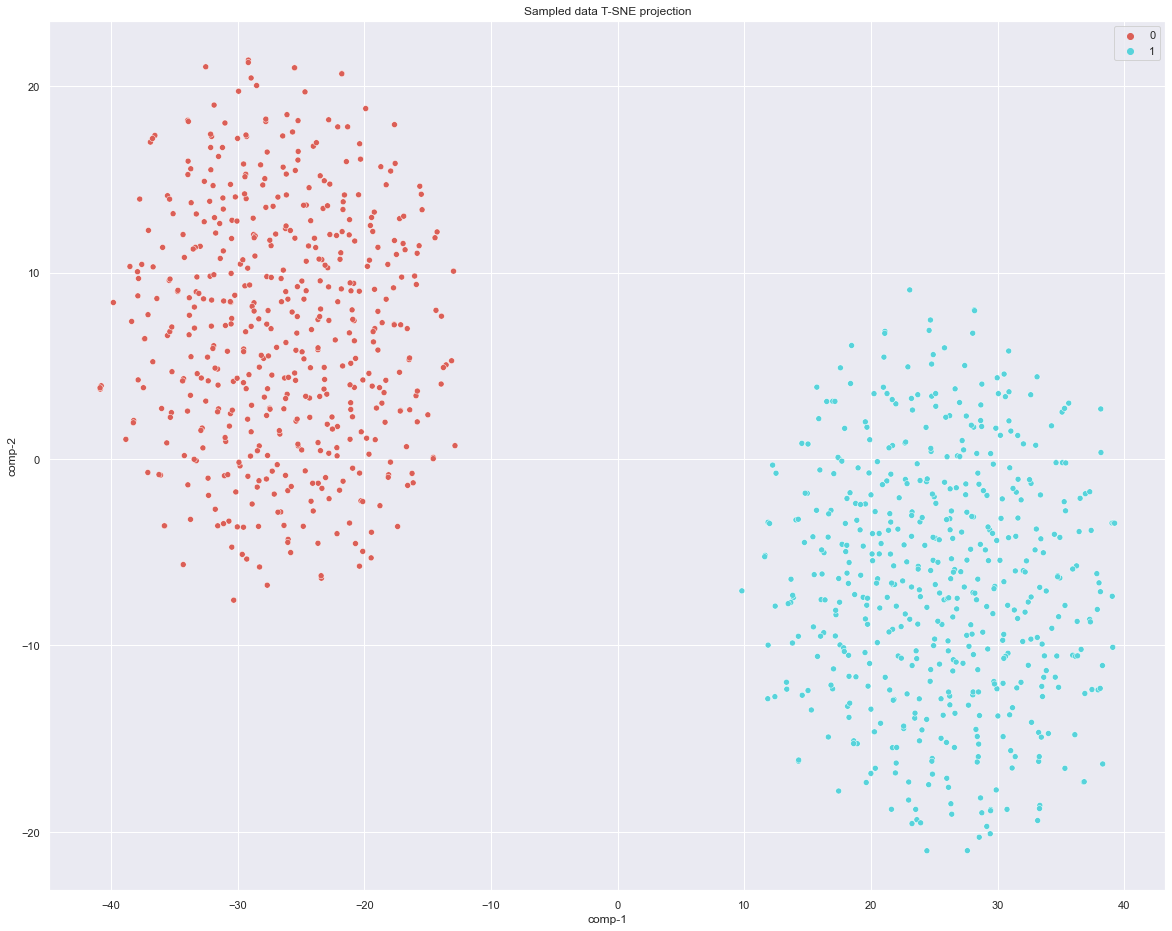

In [8]:
# TSNE

x = data.iloc[:, :p_sim['n_features']]
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
d = pd.DataFrame()
d["tt"] = data[['tt']].values.squeeze()
d["comp-1"] = z[:, 0]
d["comp-2"] = z[:, 1]

fig = plt.figure()
sns.scatterplot(x="comp-1", y="comp-2", hue=d.tt.tolist(),
            palette=sns.color_palette("hls", 2),
            data=d).set(title="Sampled data T-SNE projection")
fig.show()

# send figure to neptune
nep.send_plot(fig, "TSNE initial",num_run=0)


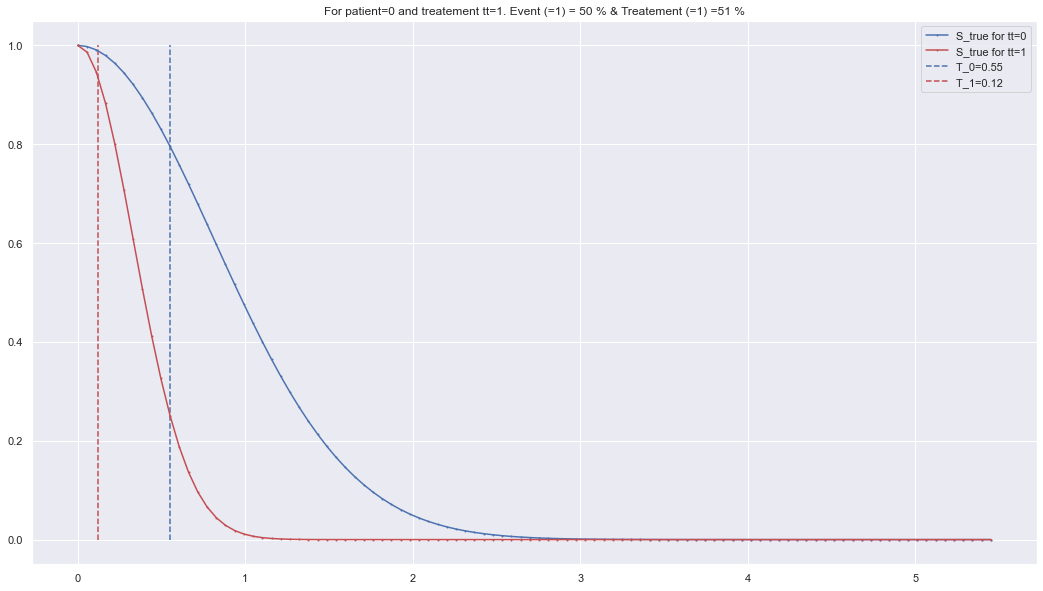

In [9]:
simu.plot_surv_true(patient=0)

# Tunning

In [10]:
#Tunning Survcaus 


tunning = Tunning(p_sim)
n_trials = 10
   
    
p_survcaus_best = tunning.get_best_hyperparameter_survcaus(n_trials=10)


[I 2021-11-22 21:24:22,987] A new study created in memory with name: no-name-99b36d46-bdf3-414d-ab82-5ee2ae2ef761
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 22 cuts instead of 25

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 22 cuts instead of 25

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 22 cuts instead of 25



0:	[0s / 0s],		train_loss: 1.6620,	train_loss_surv: 1.6619,	train_loss_wass: 0.0024,	val_loss: 1.9740,	val_loss_surv: 1.9736,	val_loss_wass: 0.0090
1:	[0s / 0s],		train_loss: 1.6005,	train_loss_surv: 1.6001,	train_loss_wass: 0.0096,	val_loss: 1.9402,	val_loss_surv: 1.9391,	val_loss_wass: 0.0295
2:	[0s / 0s],		train_loss: 1.5323,	train_loss_surv: 1.5316,	train_loss_wass: 0.0174,	val_loss: 1.9198,	val_loss_surv: 1.9187,	val_loss_wass: 0.0293
3:	[0s / 0s],		train_loss: 1.4826,	train_loss_surv: 1.4820,	train_loss_wass: 0.0149,	val_loss: 1.8937,	val_loss_surv: 1.8928,	val_loss_wass: 0.0248
4:	[0s / 1s],		train_loss: 1.4085,	train_loss_surv: 1.4081,	train_loss_wass: 0.0107,	val_loss: 1.8508,	val_loss_surv: 1.8502,	val_loss_wass: 0.0145
5:	[0s / 1s],		train_loss: 1.4507,	train_loss_surv: 1.4505,	train_loss_wass: 0.0067,	val_loss: 1.7967,	val_loss_surv: 1.7962,	val_loss_wass: 0.0129
6:	[0s / 1s],		train_loss: 1.4452,	train_loss_surv: 1.4450,	train_loss_wass: 0.0067,	val_loss: 1.8810,	val_loss_

 21%|██        | 67/320 [00:00<00:00, 665.42it/s]

12:	[0s / 3s],		train_loss: 1.3931,	train_loss_surv: 1.3927,	train_loss_wass: 0.0101,	val_loss: 1.7939,	val_loss_surv: 1.7933,	val_loss_wass: 0.0164


100%|██████████| 320/320 [00:00<00:00, 643.93it/s]
[I 2021-11-22 21:24:28,048] Trial 0 finished with value: 0.1505710394197652 and parameters: {'num_durations': 25, 'encoded_features': 10, 'alpha_wass': 0.03830672145442667, 'lr': 0.0046876888449341025}. Best is trial 0 with value: 0.1505710394197652.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 20 cuts instead of 23

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 20 cuts instead of 23

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 20 cuts instead of 23



0:	[0s / 0s],		train_loss: 1.6362,	train_loss_surv: 1.6360,	train_loss_wass: 0.0042,	val_loss: 1.9750,	val_loss_surv: 1.9746,	val_loss_wass: 0.0078
1:	[0s / 0s],		train_loss: 1.4766,	train_loss_surv: 1.4764,	train_loss_wass: 0.0044,	val_loss: 1.9471,	val_loss_surv: 1.9465,	val_loss_wass: 0.0129
2:	[0s / 0s],		train_loss: 1.4909,	train_loss_surv: 1.4903,	train_loss_wass: 0.0108,	val_loss: 1.8896,	val_loss_surv: 1.8884,	val_loss_wass: 0.0260
3:	[0s / 1s],		train_loss: 1.3731,	train_loss_surv: 1.3721,	train_loss_wass: 0.0200,	val_loss: 1.8451,	val_loss_surv: 1.8431,	val_loss_wass: 0.0427
4:	[0s / 2s],		train_loss: 1.3753,	train_loss_surv: 1.3739,	train_loss_wass: 0.0286,	val_loss: 1.8056,	val_loss_surv: 1.8032,	val_loss_wass: 0.0504
5:	[0s / 3s],		train_loss: 1.4621,	train_loss_surv: 1.4607,	train_loss_wass: 0.0284,	val_loss: 1.7515,	val_loss_surv: 1.7495,	val_loss_wass: 0.0423
6:	[0s / 4s],		train_loss: 1.3801,	train_loss_surv: 1.3790,	train_loss_wass: 0.0226,	val_loss: 1.7068,	val_loss_

  0%|          | 0/320 [00:00<?, ?it/s]

17:	[0s / 8s],		train_loss: 1.2823,	train_loss_surv: 1.2820,	train_loss_wass: 0.0060,	val_loss: 1.9505,	val_loss_surv: 1.9500,	val_loss_wass: 0.0118
18:	[0s / 8s],		train_loss: 1.3231,	train_loss_surv: 1.3228,	train_loss_wass: 0.0066,	val_loss: 1.9066,	val_loss_surv: 1.9059,	val_loss_wass: 0.0134


100%|██████████| 320/320 [00:00<00:00, 469.72it/s]
[I 2021-11-22 21:24:37,739] Trial 1 finished with value: 0.11720710915621503 and parameters: {'num_durations': 23, 'encoded_features': 16, 'alpha_wass': 0.0475676337207266, 'lr': 0.005359198357481979}. Best is trial 1 with value: 0.11720710915621503.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 24 cuts instead of 27

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 24 cuts instead of 27

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 24 cuts instead of 27



0:	[1s / 1s],		train_loss: 1.8327,	train_loss_surv: 1.8324,	train_loss_wass: 0.0142,	val_loss: 1.9880,	val_loss_surv: 1.9873,	val_loss_wass: 0.0254
1:	[1s / 2s],		train_loss: 1.8303,	train_loss_surv: 1.8300,	train_loss_wass: 0.0141,	val_loss: 1.9866,	val_loss_surv: 1.9860,	val_loss_wass: 0.0258
2:	[1s / 3s],		train_loss: 1.7477,	train_loss_surv: 1.7474,	train_loss_wass: 0.0152,	val_loss: 1.9841,	val_loss_surv: 1.9834,	val_loss_wass: 0.0262
3:	[1s / 5s],		train_loss: 1.7360,	train_loss_surv: 1.7357,	train_loss_wass: 0.0149,	val_loss: 1.9811,	val_loss_surv: 1.9804,	val_loss_wass: 0.0263
4:	[1s / 6s],		train_loss: 1.7333,	train_loss_surv: 1.7329,	train_loss_wass: 0.0161,	val_loss: 1.9778,	val_loss_surv: 1.9771,	val_loss_wass: 0.0263
5:	[0s / 7s],		train_loss: 1.6739,	train_loss_surv: 1.6735,	train_loss_wass: 0.0153,	val_loss: 1.9741,	val_loss_surv: 1.9734,	val_loss_wass: 0.0269
6:	[1s / 8s],		train_loss: 1.6927,	train_loss_surv: 1.6923,	train_loss_wass: 0.0170,	val_loss: 1.9689,	val_loss_

 22%|██▏       | 71/320 [00:00<00:00, 707.52it/s]

19:	[0s / 21s],		train_loss: 1.5332,	train_loss_surv: 1.5328,	train_loss_wass: 0.0149,	val_loss: 1.8019,	val_loss_surv: 1.8013,	val_loss_wass: 0.0257


100%|██████████| 320/320 [00:00<00:00, 820.79it/s]
[I 2021-11-22 21:24:59,446] Trial 2 finished with value: 0.14886595703130429 and parameters: {'num_durations': 27, 'encoded_features': 27, 'alpha_wass': 0.024523560031295587, 'lr': 0.0002861281500653999}. Best is trial 1 with value: 0.11720710915621503.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 23 cuts instead of 26

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 23 cuts instead of 26

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 23 cuts instead of 26



0:	[0s / 0s],		train_loss: 1.6952,	train_loss_surv: 1.6949,	train_loss_wass: 0.0040,	val_loss: 1.9310,	val_loss_surv: 1.9299,	val_loss_wass: 0.0131
1:	[0s / 0s],		train_loss: 1.5471,	train_loss_surv: 1.5462,	train_loss_wass: 0.0113,	val_loss: 1.9114,	val_loss_surv: 1.9094,	val_loss_wass: 0.0237
2:	[0s / 0s],		train_loss: 1.6522,	train_loss_surv: 1.6509,	train_loss_wass: 0.0157,	val_loss: 1.9036,	val_loss_surv: 1.9012,	val_loss_wass: 0.0281
3:	[0s / 1s],		train_loss: 1.5202,	train_loss_surv: 1.5191,	train_loss_wass: 0.0131,	val_loss: 1.8111,	val_loss_surv: 1.8091,	val_loss_wass: 0.0232
4:	[0s / 1s],		train_loss: 1.4658,	train_loss_surv: 1.4647,	train_loss_wass: 0.0126,	val_loss: 1.7858,	val_loss_surv: 1.7843,	val_loss_wass: 0.0179
5:	[0s / 2s],		train_loss: 1.5063,	train_loss_surv: 1.5057,	train_loss_wass: 0.0075,	val_loss: 2.2605,	val_loss_surv: 2.2589,	val_loss_wass: 0.0187
6:	[1s / 3s],		train_loss: 1.4512,	train_loss_surv: 1.4504,	train_loss_wass: 0.0104,	val_loss: 1.7991,	val_loss_

 28%|██▊       | 89/320 [00:00<00:00, 883.74it/s]

12:	[1s / 11s],		train_loss: 1.5013,	train_loss_surv: 1.4970,	train_loss_wass: 0.0505,	val_loss: 1.7726,	val_loss_surv: 1.7674,	val_loss_wass: 0.0621


100%|██████████| 320/320 [00:00<00:00, 883.44it/s]
[I 2021-11-22 21:25:11,259] Trial 3 finished with value: 0.13309470035761956 and parameters: {'num_durations': 26, 'encoded_features': 27, 'alpha_wass': 0.08443357272120908, 'lr': 0.00887643461104182}. Best is trial 1 with value: 0.11720710915621503.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 19 cuts instead of 21

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 19 cuts instead of 21

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 19 cuts instead of 21



0:	[0s / 0s],		train_loss: 1.5703,	train_loss_surv: 1.5700,	train_loss_wass: 0.0116,	val_loss: 1.9188,	val_loss_surv: 1.9182,	val_loss_wass: 0.0256
1:	[0s / 0s],		train_loss: 1.5542,	train_loss_surv: 1.5539,	train_loss_wass: 0.0136,	val_loss: 1.9127,	val_loss_surv: 1.9120,	val_loss_wass: 0.0276
2:	[0s / 0s],		train_loss: 1.4983,	train_loss_surv: 1.4980,	train_loss_wass: 0.0139,	val_loss: 1.9031,	val_loss_surv: 1.9023,	val_loss_wass: 0.0289
3:	[0s / 1s],		train_loss: 1.4682,	train_loss_surv: 1.4679,	train_loss_wass: 0.0127,	val_loss: 1.8897,	val_loss_surv: 1.8890,	val_loss_wass: 0.0286
4:	[0s / 1s],		train_loss: 1.3892,	train_loss_surv: 1.3889,	train_loss_wass: 0.0126,	val_loss: 1.8713,	val_loss_surv: 1.8706,	val_loss_wass: 0.0271
5:	[0s / 2s],		train_loss: 1.4654,	train_loss_surv: 1.4651,	train_loss_wass: 0.0128,	val_loss: 1.8465,	val_loss_surv: 1.8459,	val_loss_wass: 0.0248
6:	[0s / 2s],		train_loss: 1.4005,	train_loss_surv: 1.4002,	train_loss_wass: 0.0118,	val_loss: 1.8216,	val_loss_

 21%|██        | 66/320 [00:00<00:00, 650.59it/s]

19:	[0s / 9s],		train_loss: 1.2999,	train_loss_surv: 1.2997,	train_loss_wass: 0.0082,	val_loss: 1.6361,	val_loss_surv: 1.6358,	val_loss_wass: 0.0150


100%|██████████| 320/320 [00:00<00:00, 605.74it/s]
[I 2021-11-22 21:25:21,673] Trial 4 finished with value: 0.12013872126820498 and parameters: {'num_durations': 21, 'encoded_features': 19, 'alpha_wass': 0.025370930660172958, 'lr': 0.000787416417137523}. Best is trial 1 with value: 0.11720710915621503.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 25 cuts instead of 29

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 25 cuts instead of 29

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 25 cuts instead of 29



0:	[0s / 0s],		train_loss: 1.8644,	train_loss_surv: 1.8642,	train_loss_wass: 0.0058,	val_loss: 2.0957,	val_loss_surv: 2.0954,	val_loss_wass: 0.0111
1:	[0s / 0s],		train_loss: 1.8118,	train_loss_surv: 1.8116,	train_loss_wass: 0.0057,	val_loss: 2.0958,	val_loss_surv: 2.0955,	val_loss_wass: 0.0111
2:	[0s / 0s],		train_loss: 1.8103,	train_loss_surv: 1.8101,	train_loss_wass: 0.0059,	val_loss: 2.0954,	val_loss_surv: 2.0951,	val_loss_wass: 0.0111
3:	[0s / 1s],		train_loss: 1.7927,	train_loss_surv: 1.7925,	train_loss_wass: 0.0059,	val_loss: 2.0949,	val_loss_surv: 2.0946,	val_loss_wass: 0.0109
4:	[0s / 1s],		train_loss: 1.7597,	train_loss_surv: 1.7595,	train_loss_wass: 0.0058,	val_loss: 2.0941,	val_loss_surv: 2.0937,	val_loss_wass: 0.0109
5:	[0s / 1s],		train_loss: 1.7807,	train_loss_surv: 1.7805,	train_loss_wass: 0.0059,	val_loss: 2.0927,	val_loss_surv: 2.0924,	val_loss_wass: 0.0110
6:	[0s / 1s],		train_loss: 1.7362,	train_loss_surv: 1.7360,	train_loss_wass: 0.0059,	val_loss: 2.0910,	val_loss_

 21%|██        | 67/320 [00:00<00:00, 661.70it/s]

19:	[0s / 5s],		train_loss: 1.5431,	train_loss_surv: 1.5429,	train_loss_wass: 0.0059,	val_loss: 1.9557,	val_loss_surv: 1.9553,	val_loss_wass: 0.0115


100%|██████████| 320/320 [00:00<00:00, 554.72it/s]
[I 2021-11-22 21:25:27,762] Trial 5 finished with value: 0.13141789772581075 and parameters: {'num_durations': 29, 'encoded_features': 27, 'alpha_wass': 0.03126733698343531, 'lr': 0.00028927045408751276}. Best is trial 1 with value: 0.11720710915621503.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 21 cuts instead of 24

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 21 cuts instead of 24

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 21 cuts instead of 24



0:	[0s / 0s],		train_loss: 1.6968,	train_loss_surv: 1.6963,	train_loss_wass: 0.0061,	val_loss: 1.9357,	val_loss_surv: 1.9344,	val_loss_wass: 0.0159
1:	[0s / 0s],		train_loss: 1.5524,	train_loss_surv: 1.5513,	train_loss_wass: 0.0130,	val_loss: 1.9099,	val_loss_surv: 1.9077,	val_loss_wass: 0.0279
2:	[0s / 0s],		train_loss: 1.5416,	train_loss_surv: 1.5404,	train_loss_wass: 0.0144,	val_loss: 1.8691,	val_loss_surv: 1.8670,	val_loss_wass: 0.0261
3:	[0s / 1s],		train_loss: 1.4483,	train_loss_surv: 1.4471,	train_loss_wass: 0.0148,	val_loss: 1.8233,	val_loss_surv: 1.8210,	val_loss_wass: 0.0288
4:	[0s / 2s],		train_loss: 1.4506,	train_loss_surv: 1.4493,	train_loss_wass: 0.0169,	val_loss: 1.7956,	val_loss_surv: 1.7930,	val_loss_wass: 0.0333
5:	[0s / 2s],		train_loss: 1.4477,	train_loss_surv: 1.4461,	train_loss_wass: 0.0197,	val_loss: 1.7849,	val_loss_surv: 1.7815,	val_loss_wass: 0.0432
6:	[1s / 3s],		train_loss: 1.4186,	train_loss_surv: 1.4168,	train_loss_wass: 0.0228,	val_loss: 1.7792,	val_loss_

 23%|██▎       | 75/320 [00:00<00:00, 746.30it/s]

14:	[0s / 7s],		train_loss: 1.3252,	train_loss_surv: 1.3248,	train_loss_wass: 0.0046,	val_loss: 1.7837,	val_loss_surv: 1.7830,	val_loss_wass: 0.0088


100%|██████████| 320/320 [00:00<00:00, 797.84it/s]
[I 2021-11-22 21:25:35,514] Trial 6 finished with value: 0.10763569317508281 and parameters: {'num_durations': 24, 'encoded_features': 17, 'alpha_wass': 0.07909694084520515, 'lr': 0.004051401714845319}. Best is trial 6 with value: 0.10763569317508281.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 18 cuts instead of 20

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 18 cuts instead of 20

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 18 cuts instead of 20



0:	[0s / 0s],		train_loss: 1.7087,	train_loss_surv: 1.7087,	train_loss_wass: 0.0023,	val_loss: 1.6690,	val_loss_surv: 1.6689,	val_loss_wass: 0.0041
1:	[0s / 0s],		train_loss: 1.5900,	train_loss_surv: 1.5900,	train_loss_wass: 0.0021,	val_loss: 1.6689,	val_loss_surv: 1.6688,	val_loss_wass: 0.0043
2:	[0s / 0s],		train_loss: 1.5869,	train_loss_surv: 1.5868,	train_loss_wass: 0.0022,	val_loss: 1.6683,	val_loss_surv: 1.6682,	val_loss_wass: 0.0044
3:	[0s / 0s],		train_loss: 1.5811,	train_loss_surv: 1.5811,	train_loss_wass: 0.0024,	val_loss: 1.6674,	val_loss_surv: 1.6673,	val_loss_wass: 0.0047
4:	[0s / 0s],		train_loss: 1.5521,	train_loss_surv: 1.5521,	train_loss_wass: 0.0022,	val_loss: 1.6662,	val_loss_surv: 1.6660,	val_loss_wass: 0.0049
5:	[0s / 0s],		train_loss: 1.5378,	train_loss_surv: 1.5378,	train_loss_wass: 0.0026,	val_loss: 1.6643,	val_loss_surv: 1.6642,	val_loss_wass: 0.0052
6:	[0s / 1s],		train_loss: 1.5400,	train_loss_surv: 1.5399,	train_loss_wass: 0.0026,	val_loss: 1.6613,	val_loss_

100%|██████████| 320/320 [00:00<00:00, 616.41it/s]
[I 2021-11-22 21:25:39,631] Trial 7 finished with value: 0.1167009975697992 and parameters: {'num_durations': 20, 'encoded_features': 19, 'alpha_wass': 0.023542285343802392, 'lr': 0.00031993714922666435}. Best is trial 6 with value: 0.10763569317508281.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 26 cuts instead of 30

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 26 cuts instead of 30

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 26 cuts instead of 30



0:	[0s / 0s],		train_loss: 1.8877,	train_loss_surv: 1.8872,	train_loss_wass: 0.0072,	val_loss: 2.3652,	val_loss_surv: 2.3639,	val_loss_wass: 0.0176
1:	[0s / 0s],		train_loss: 1.7634,	train_loss_surv: 1.7627,	train_loss_wass: 0.0089,	val_loss: 2.3645,	val_loss_surv: 2.3631,	val_loss_wass: 0.0187
2:	[0s / 0s],		train_loss: 1.7639,	train_loss_surv: 1.7633,	train_loss_wass: 0.0086,	val_loss: 2.3641,	val_loss_surv: 2.3627,	val_loss_wass: 0.0198
3:	[0s / 0s],		train_loss: 1.7239,	train_loss_surv: 1.7232,	train_loss_wass: 0.0102,	val_loss: 2.3622,	val_loss_surv: 2.3606,	val_loss_wass: 0.0210
4:	[0s / 1s],		train_loss: 1.7277,	train_loss_surv: 1.7269,	train_loss_wass: 0.0107,	val_loss: 2.3585,	val_loss_surv: 2.3569,	val_loss_wass: 0.0214
5:	[0s / 1s],		train_loss: 1.7090,	train_loss_surv: 1.7082,	train_loss_wass: 0.0111,	val_loss: 2.3529,	val_loss_surv: 2.3513,	val_loss_wass: 0.0214
6:	[0s / 1s],		train_loss: 1.7314,	train_loss_surv: 1.7307,	train_loss_wass: 0.0097,	val_loss: 2.3441,	val_loss_

 18%|█▊        | 56/320 [00:00<00:00, 551.60it/s]

19:	[0s / 5s],		train_loss: 1.4808,	train_loss_surv: 1.4804,	train_loss_wass: 0.0062,	val_loss: 2.1867,	val_loss_surv: 2.1859,	val_loss_wass: 0.0111


100%|██████████| 320/320 [00:00<00:00, 697.78it/s]
[I 2021-11-22 21:25:46,229] Trial 8 finished with value: 0.15377471597094758 and parameters: {'num_durations': 30, 'encoded_features': 23, 'alpha_wass': 0.07338606430938258, 'lr': 0.0006064210632632591}. Best is trial 6 with value: 0.10763569317508281.
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 25 cuts instead of 29

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 25 cuts instead of 29

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 25 cuts instead of 29



0:	[0s / 0s],		train_loss: 1.8139,	train_loss_surv: 1.8128,	train_loss_wass: 0.0139,	val_loss: 1.8140,	val_loss_surv: 1.8119,	val_loss_wass: 0.0273
1:	[0s / 0s],		train_loss: 1.7068,	train_loss_surv: 1.7055,	train_loss_wass: 0.0176,	val_loss: 1.8007,	val_loss_surv: 1.7985,	val_loss_wass: 0.0274
2:	[1s / 1s],		train_loss: 1.6553,	train_loss_surv: 1.6540,	train_loss_wass: 0.0163,	val_loss: 1.7756,	val_loss_surv: 1.7739,	val_loss_wass: 0.0228
3:	[0s / 2s],		train_loss: 1.6053,	train_loss_surv: 1.6044,	train_loss_wass: 0.0122,	val_loss: 1.7504,	val_loss_surv: 1.7490,	val_loss_wass: 0.0180
4:	[0s / 3s],		train_loss: 1.5671,	train_loss_surv: 1.5664,	train_loss_wass: 0.0090,	val_loss: 1.7218,	val_loss_surv: 1.7209,	val_loss_wass: 0.0121
5:	[0s / 3s],		train_loss: 1.5301,	train_loss_surv: 1.5297,	train_loss_wass: 0.0053,	val_loss: 1.7043,	val_loss_surv: 1.7037,	val_loss_wass: 0.0082
6:	[0s / 3s],		train_loss: 1.5042,	train_loss_surv: 1.5039,	train_loss_wass: 0.0040,	val_loss: 1.6896,	val_loss_

  0%|          | 0/320 [00:00<?, ?it/s]

18:	[0s / 6s],		train_loss: 1.3609,	train_loss_surv: 1.3608,	train_loss_wass: 0.0011,	val_loss: 1.5012,	val_loss_surv: 1.5011,	val_loss_wass: 0.0018
19:	[0s / 6s],		train_loss: 1.2884,	train_loss_surv: 1.2883,	train_loss_wass: 0.0010,	val_loss: 1.4802,	val_loss_surv: 1.4801,	val_loss_wass: 0.0022


100%|██████████| 320/320 [00:00<00:00, 704.42it/s]
[I 2021-11-22 21:25:53,210] Trial 9 finished with value: 0.12069609890095871 and parameters: {'num_durations': 29, 'encoded_features': 13, 'alpha_wass': 0.0777037160516002, 'lr': 0.0021928697744413826}. Best is trial 6 with value: 0.10763569317508281.


In [11]:
# Tunning BART 

p_bart_best = tunning.get_best_hyperparameter_bart(n_trials=1)
            

[I 2021-11-22 21:25:53,233] A new study created in memory with name: no-name-ad31ca64-dfbf-4668-807b-7aaa3a374acc
100%|██████████| 320/320 [00:03<00:00, 104.93it/s]
[I 2021-11-22 21:25:56,905] Trial 0 finished with value: 0.1253916849374264 and parameters: {'num_trees': 22, 'max_features': 'all', 'max_depth': 6, 'alpha': 0.2141609990238301}. Best is trial 0 with value: 0.1253916849374264.


# Training 

In [25]:

p_survcaus = p_survcaus_best.copy()

p_survcaus['patience'] = 2
p_survcaus['epochs'] = 20
p_survcaus['batch_size'] = 256
p_survcaus['num_durations'] = 25 #20
#p_survcaus['encoded_features'] =12
    
print("Best hyperparameter for survcaus : ", p_survcaus)
print("Best hyperparameter for BART : ", p_bart_best)
    
Ev = Evaluation(p_sim, p_survcaus)


list_models =  ["SurvCaus", "SurvCaus_0",'BART', 'CoxPH','DeepSurv','EST','RSF']
print("Choosed models : ", list_models)

nep.send_dict(p_survcaus, "p_survcaus",num_run=0)
nep.send_dict(p_bart_best, "p_bart_best",num_run=0)

Best hyperparameter for survcaus :  {'num_durations': 25, 'encoded_features': 17, 'alpha_wass': 0.07909694084520515, 'lr': 0.004051401714845319, 'patience': 2, 'epochs': 20, 'batch_size': 256}
Best hyperparameter for BART :  {'num_trees': 22, 'max_features': 'all', 'max_depth': 6, 'alpha': 0.2141609990238301}
Choosed models :  ['SurvCaus', 'SurvCaus_0', 'BART', 'CoxPH', 'DeepSurv', 'EST', 'RSF']


/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 22 cuts instead of 25

/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 22 cuts instead of 25



SurvCaus
{'num_durations': 25, 'encoded_features': 17, 'alpha_wass': 0.07909694084520515, 'lr': 0.004051401714845319, 'patience': 2, 'epochs': 20, 'batch_size': 256}


/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 22 cuts instead of 25



0:	[0s / 0s],		train_loss: 1.7141,	train_loss_surv: 1.7138,	train_loss_wass: 0.0034,	val_loss: 1.8760,	val_loss_surv: 1.8749,	val_loss_wass: 0.0139
1:	[0s / 0s],		train_loss: 1.6023,	train_loss_surv: 1.6017,	train_loss_wass: 0.0087,	val_loss: 1.8650,	val_loss_surv: 1.8631,	val_loss_wass: 0.0246
2:	[0s / 0s],		train_loss: 1.5100,	train_loss_surv: 1.5092,	train_loss_wass: 0.0097,	val_loss: 1.8353,	val_loss_surv: 1.8332,	val_loss_wass: 0.0258
3:	[0s / 0s],		train_loss: 1.4663,	train_loss_surv: 1.4654,	train_loss_wass: 0.0124,	val_loss: 1.8223,	val_loss_surv: 1.8198,	val_loss_wass: 0.0317
4:	[0s / 0s],		train_loss: 1.4643,	train_loss_surv: 1.4629,	train_loss_wass: 0.0175,	val_loss: 1.8274,	val_loss_surv: 1.8238,	val_loss_wass: 0.0444
5:	[0s / 0s],		train_loss: 1.4590,	train_loss_surv: 1.4578,	train_loss_wass: 0.0152,	val_loss: 1.7900,	val_loss_surv: 1.7865,	val_loss_wass: 0.0435
6:	[0s / 1s],		train_loss: 1.4513,	train_loss_surv: 1.4502,	train_loss_wass: 0.0142,	val_loss: 1.7487,	val_loss_

  0%|          | 0/320 [00:00<?, ?it/s]

11:	[0s / 1s],		train_loss: 1.4485,	train_loss_surv: 1.4481,	train_loss_wass: 0.0051,	val_loss: 1.6673,	val_loss_surv: 1.6663,	val_loss_wass: 0.0126
12:	[0s / 2s],		train_loss: 1.4363,	train_loss_surv: 1.4357,	train_loss_wass: 0.0070,	val_loss: 1.6872,	val_loss_surv: 1.6858,	val_loss_wass: 0.0181


100%|██████████| 320/320 [00:00<00:00, 1277.28it/s]
/home/aabraich/anaconda3/lib/python3.8/site-packages/pycox/preprocessing/discretization.py:37: UserWarning:

cuts are not unique, continue with 22 cuts instead of 25



SurvCaus_0
{'num_durations': 25, 'encoded_features': 17, 'alpha_wass': 0.0, 'lr': 0.004051401714845319, 'patience': 2, 'epochs': 20, 'batch_size': 256}
0:	[0s / 0s],		train_loss: 1.7193,	train_loss_surv: 1.7193,	train_loss_wass: 0.0038,	val_loss: 1.8848,	val_loss_surv: 1.8848,	val_loss_wass: 0.0170
1:	[0s / 0s],		train_loss: 1.5892,	train_loss_surv: 1.5892,	train_loss_wass: 0.0067,	val_loss: 1.8419,	val_loss_surv: 1.8419,	val_loss_wass: 0.0318
2:	[0s / 0s],		train_loss: 1.5052,	train_loss_surv: 1.5052,	train_loss_wass: 0.0105,	val_loss: 1.8026,	val_loss_surv: 1.8026,	val_loss_wass: 0.0358
3:	[0s / 1s],		train_loss: 1.4680,	train_loss_surv: 1.4680,	train_loss_wass: 0.0162,	val_loss: 1.7652,	val_loss_surv: 1.7652,	val_loss_wass: 0.0391
4:	[0s / 2s],		train_loss: 1.5113,	train_loss_surv: 1.5113,	train_loss_wass: 0.0133,	val_loss: 1.7311,	val_loss_surv: 1.7311,	val_loss_wass: 0.0405
5:	[0s / 3s],		train_loss: 1.4493,	train_loss_surv: 1.4493,	train_loss_wass: 0.0202,	val_loss: 1.7116,	val_l

 29%|██▉       | 94/320 [00:00<00:00, 930.73it/s]

10:	[0s / 5s],		train_loss: 1.3967,	train_loss_surv: 1.3967,	train_loss_wass: 0.0073,	val_loss: 1.6653,	val_loss_surv: 1.6653,	val_loss_wass: 0.0120


100%|██████████| 320/320 [00:00<00:00, 1064.13it/s]


BART


100%|██████████| 320/320 [00:00<00:00, 809.84it/s]


CoxPH
Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 370.977 - ||grad||^2 = 136.59806
 * Iteration #2 - Loss = 346.707 - ||grad||^2 = 121.80040
 * Iteration #3 - Loss = 330.584 - ||grad||^2 = 109.19003
 * Iteration #4 - Loss = 318.684 - ||grad||^2 = 98.12979
 * Iteration #5 - Loss = 309.471 - ||grad||^2 = 88.32252
 * Iteration #6 - Loss = 302.130 - ||grad||^2 = 79.57650
 * Iteration #7 - Loss = 296.154 - ||grad||^2 = 71.74846
 * Iteration #8 - Loss = 291.210 - ||grad||^2 = 64.72360
 * Iteration #9 - Loss = 287.067 - ||grad||^2 = 58.40653
 * Iteration #10 - Loss = 283.563 - ||grad||^2 = 52.71648
 * Iteration #11 - Loss = 280.578 - ||grad||^2 = 47.58428
 * Iteration #12 - Loss = 278.028 - ||grad||^2 = 42.95032
 * Iteration #13 - Loss = 275.845 - ||grad||^2 = 38.76298
 * Iteration #14 - Loss = 273.979 - ||grad||^2 = 34.97740
 * Iteration #15 - Loss = 272.387 - ||grad||^2 = 31.55437
 * Iteration #16 - Loss = 271.035 - ||grad||^2 = 28.45935
 * Iteration #17 - Loss = 269.890

 12%|█▏        | 38/320 [00:00<00:00, 374.01it/s]

 * Iteration #97 - Loss = 934.827 - ||grad||^2 = 0.01325
 * Iteration #98 - Loss = 934.827 - ||grad||^2 = 0.01192
 * Iteration #99 - Loss = 934.827 - ||grad||^2 = 0.01073
 * Iteration #100 - Loss = 934.827 - ||grad||^2 = 0.00966
Converged after 100 iterations.


100%|██████████| 320/320 [00:00<00:00, 732.05it/s]


DeepSurv




100%|██████████| 320/320 [00:00<00:00, 972.62it/s]


EST


100%|██████████| 320/320 [00:00<00:00, 758.32it/s]


RSF


100%|██████████| 320/320 [00:00<00:00, 886.30it/s]


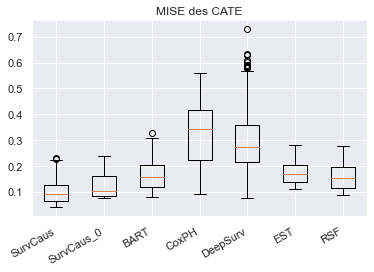

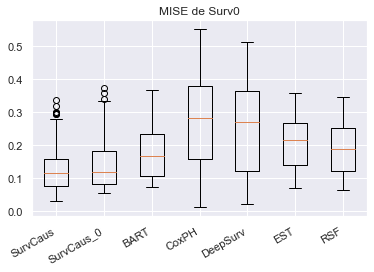

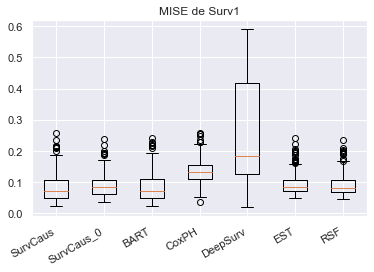

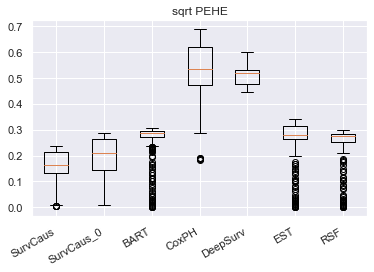

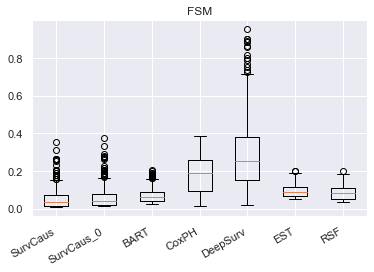

In [26]:
Ev.All_Results(list_models=list_models,
                        is_train=False,params_bart=p_bart_best)

# Benchmark

In [27]:
# Bilan of benchmark
nep.send_data(Ev.bilan_benchmark, "bilan_benchmark",num_run=0)
Ev.bilan_benchmark


,models,Mise0,Mise1,CATE,PEHE,FSM
0,SurvCaus,"(0.125, 0.06)","(0.082, 0.043)","(0.099, 0.044)","(0.165, 0.053)","(0.053, 0.055)"
1,SurvCaus_0,"(0.141, 0.07)","(0.088, 0.035)","(0.124, 0.046)","(0.198, 0.069)","(0.062, 0.059)"
2,BART,"(0.178, 0.071)","(0.084, 0.046)","(0.163, 0.052)","(0.267, 0.058)","(0.073, 0.038)"
3,CoxPH,"(0.271, 0.143)","(0.134, 0.038)","(0.325, 0.119)","(0.545, 0.086)","(0.182, 0.1)"
4,DeepSurv,"(0.252, 0.132)","(0.263, 0.173)","(0.298, 0.119)","(0.51, 0.038)","(0.294, 0.19)"
5,EST,"(0.207, 0.072)","(0.096, 0.033)","(0.171, 0.038)","(0.273, 0.064)","(0.095, 0.034)"
6,RSF,"(0.193, 0.07)","(0.093, 0.034)","(0.158, 0.047)","(0.257, 0.056)","(0.085, 0.036)"


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.000s...
[t-SNE] Computed neighbors for 600 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.054451
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.400082
[t-SNE] KL divergence after 1000 iterations: 0.611355


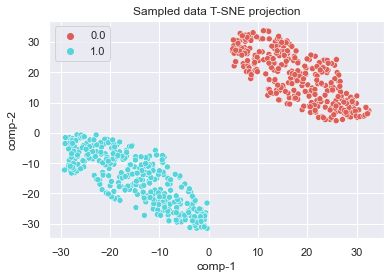

In [28]:
def get_repr(Ev):
    repr = Ev.SC.net.get_repr(torch.tensor(Ev.data.x_train))
    # repr to numpy
    repr = repr.detach().numpy()
    t = Ev.data.x_train[:,-1]
    return repr,t

def tsne_f(repr,t):
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(repr)
    d = pd.DataFrame()
    d["tt"] = t
    d["comp-1"] = z[:, 0]
    d["comp-2"] = z[:, 1]

    fig = plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=d.tt.tolist(),
                palette=sns.color_palette("hls", 2),
                data=d).set(title="Sampled data T-SNE projection")
    plt.close()
    return fig
    
    
repres,t = get_repr(Ev)
tsne_survcaus_final = tsne_f(repres,t)

nep.send_plot(tsne_survcaus_final, "TSNE survcaus final",num_run=0)
tsne_survcaus_final

In [29]:
Ev.box_plot_cate
nep.send_plot(Ev.box_plot_cate, "box_plot_cate",num_run=0)


modifier S,
experiment
log - neptune
tables 
lancer :  wd, lin/nonlin, 
pas oublier brca !! 


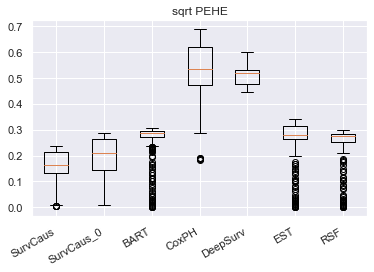

In [30]:
nep.send_plot(Ev.box_plot_pehe, "box_plot_pehe",num_run=0)
Ev.box_plot_pehe


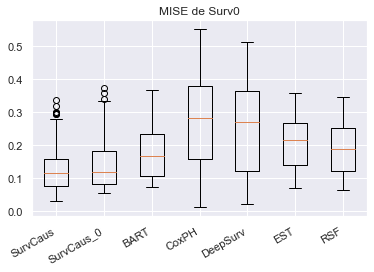

In [31]:
nep.send_plot(Ev.box_plot_surv0, "box_plot_surv0",num_run=0)
Ev.box_plot_surv0


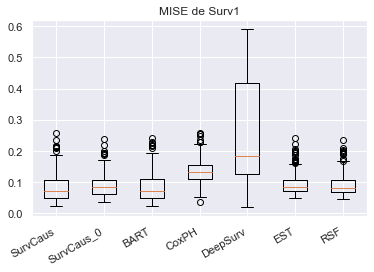

In [32]:
nep.send_plot(Ev.box_plot_surv1, "box_plot_surv1",num_run=0)
Ev.box_plot_surv1


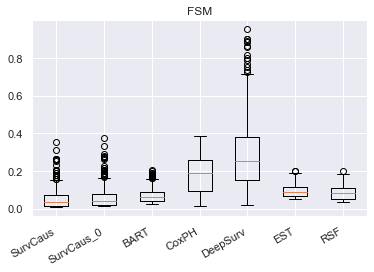

In [33]:
nep.send_plot(Ev.box_plot_FSM, "box_plot_FSM",num_run=0)
Ev.box_plot_FSM


(p_ours,p_bench) = (175, 175)
(p_ours,p_bench) = (175, 210)
(p_ours,p_bench) = (175, 43)
(p_ours,p_bench) = (175, 108)
(p_ours,p_bench) = (175, 111)
(p_ours,p_bench) = (175, 27)
(p_ours,p_bench) = (175, 94)


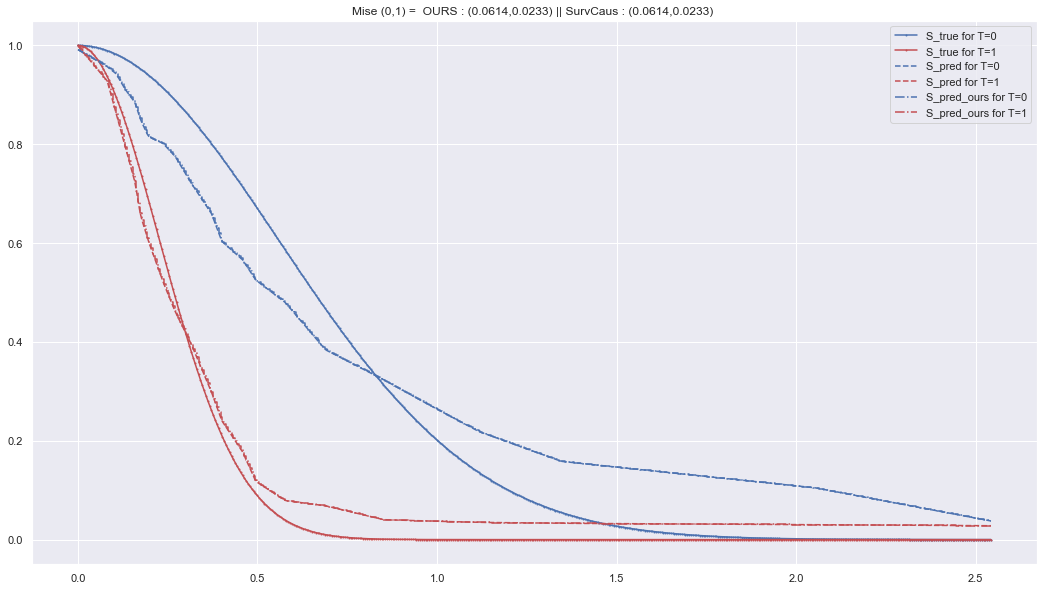

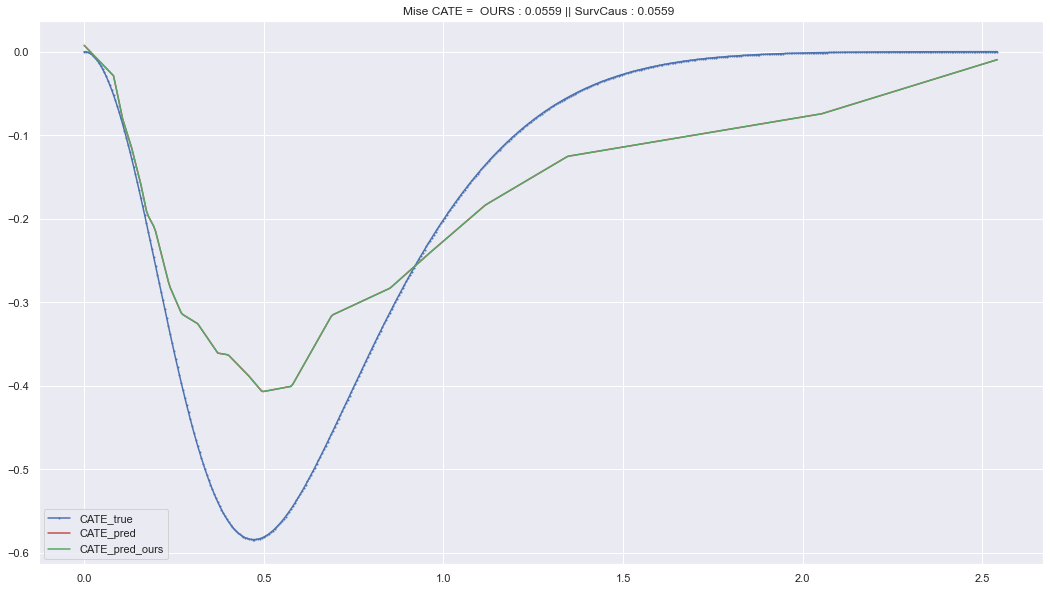

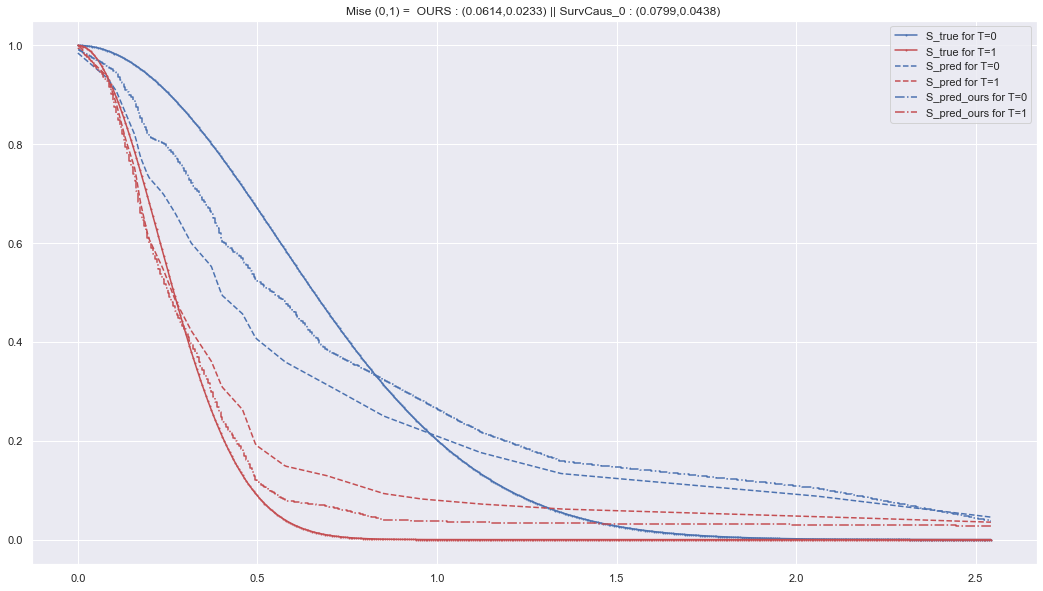

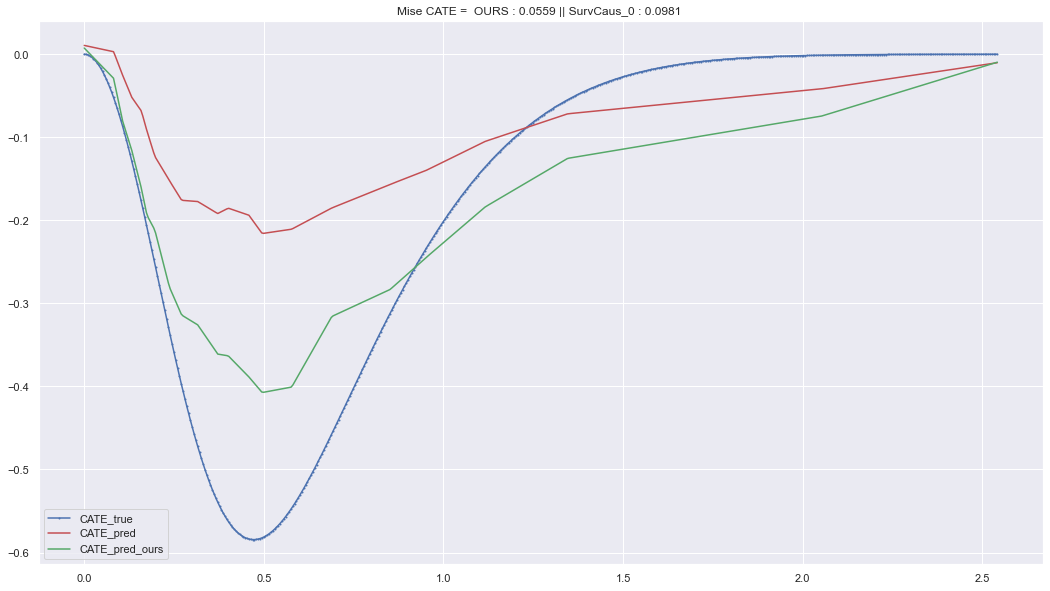

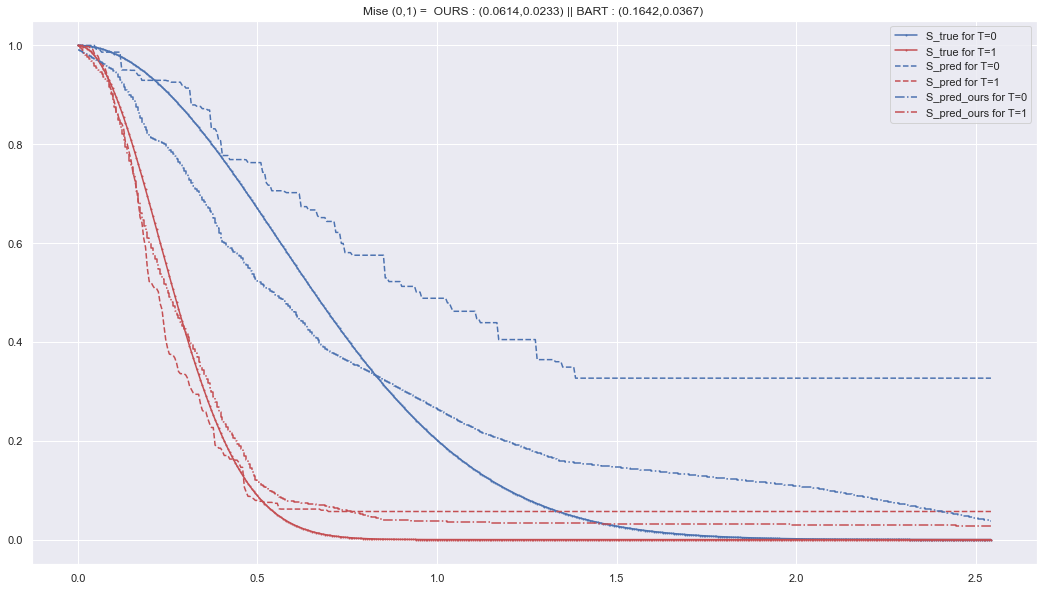

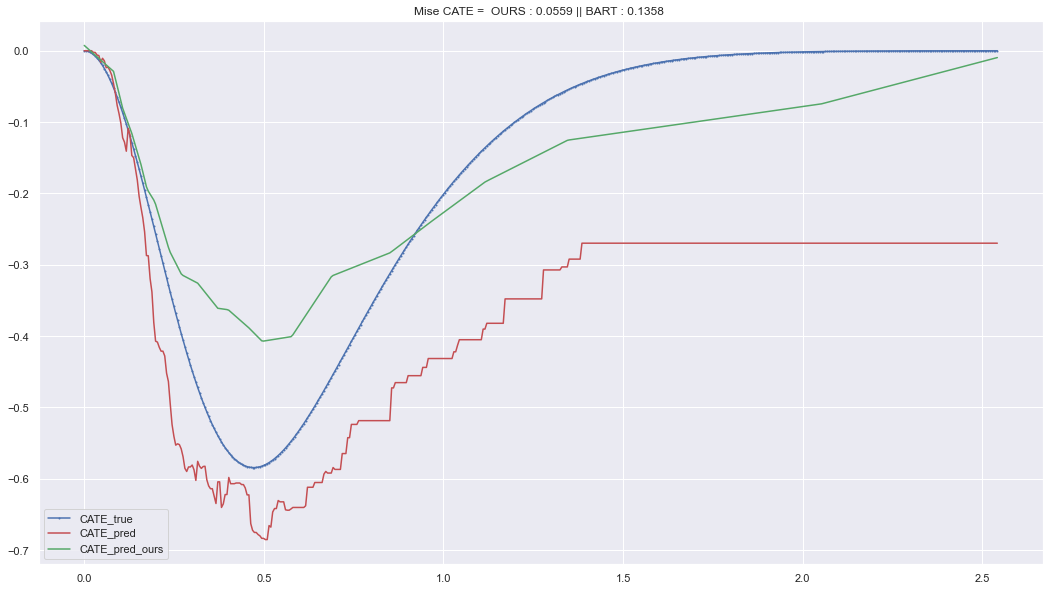

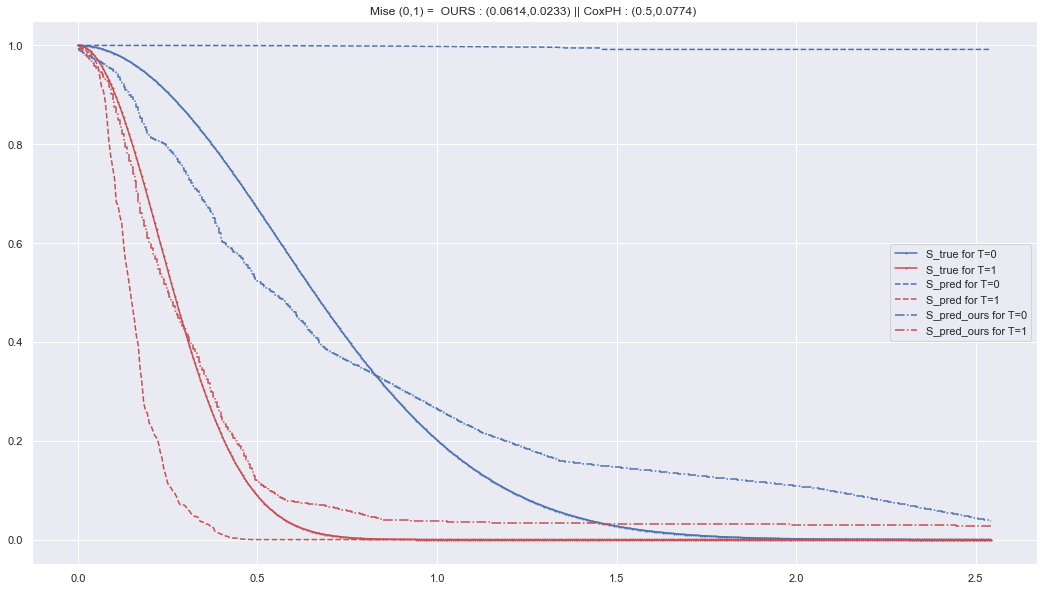

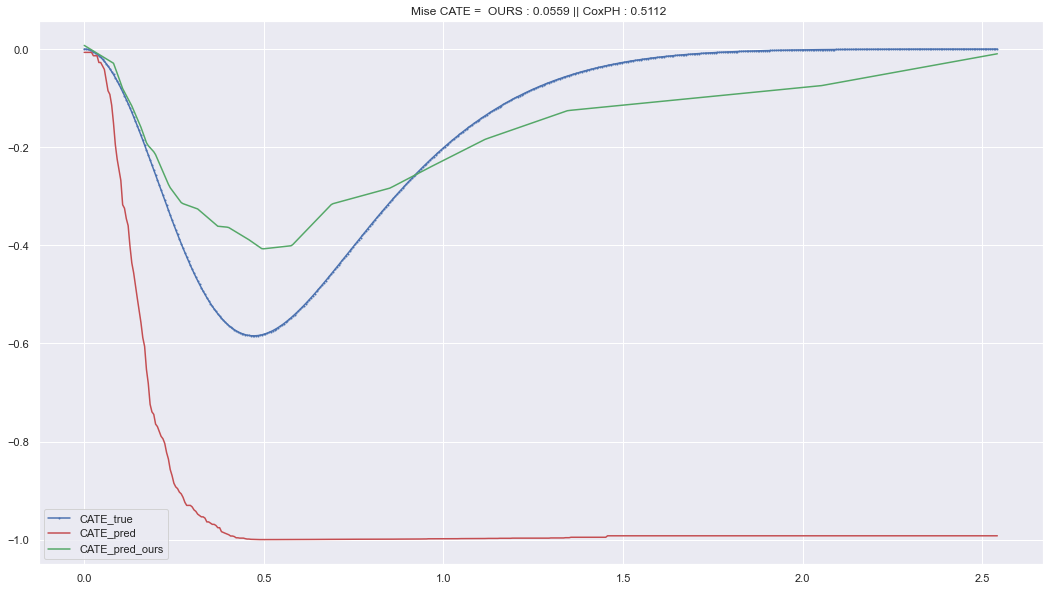

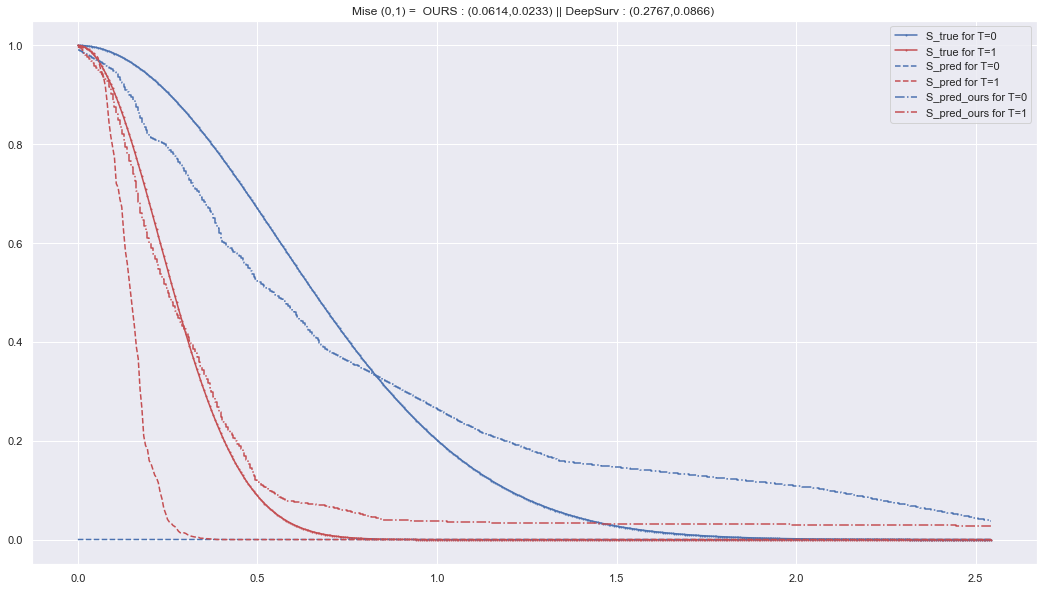

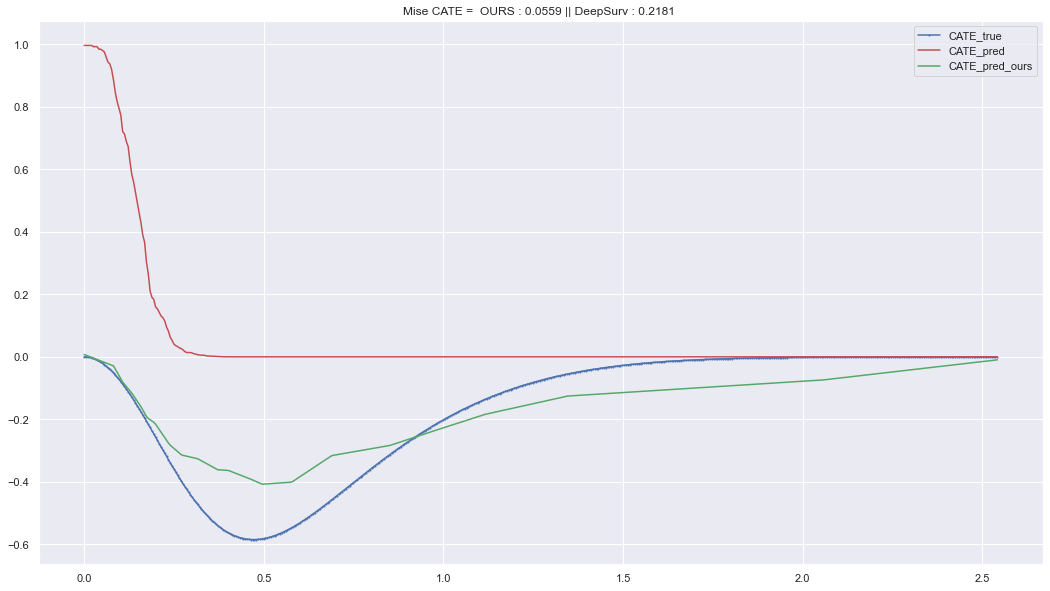

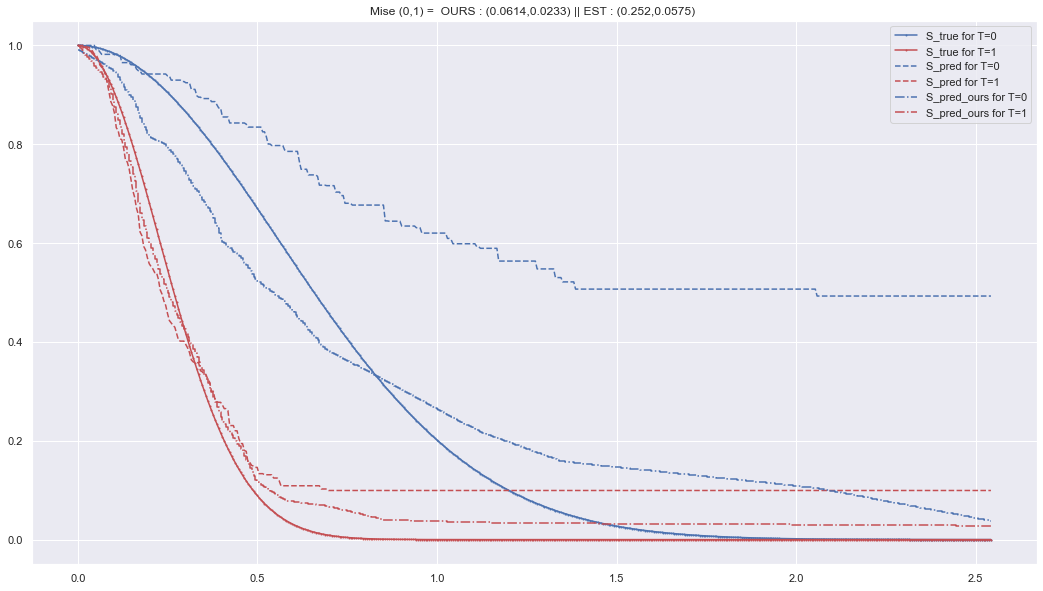

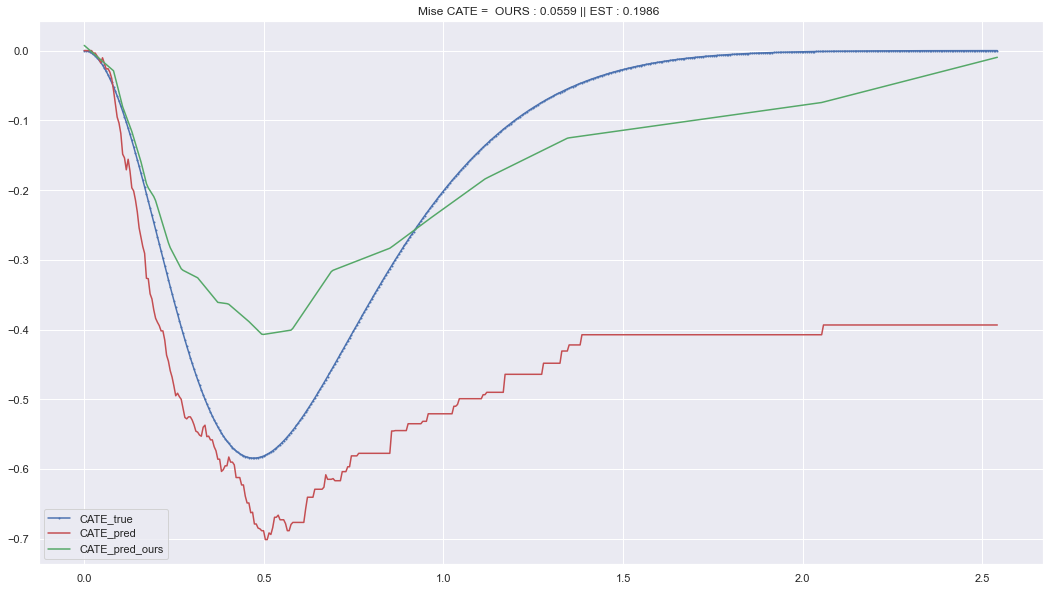

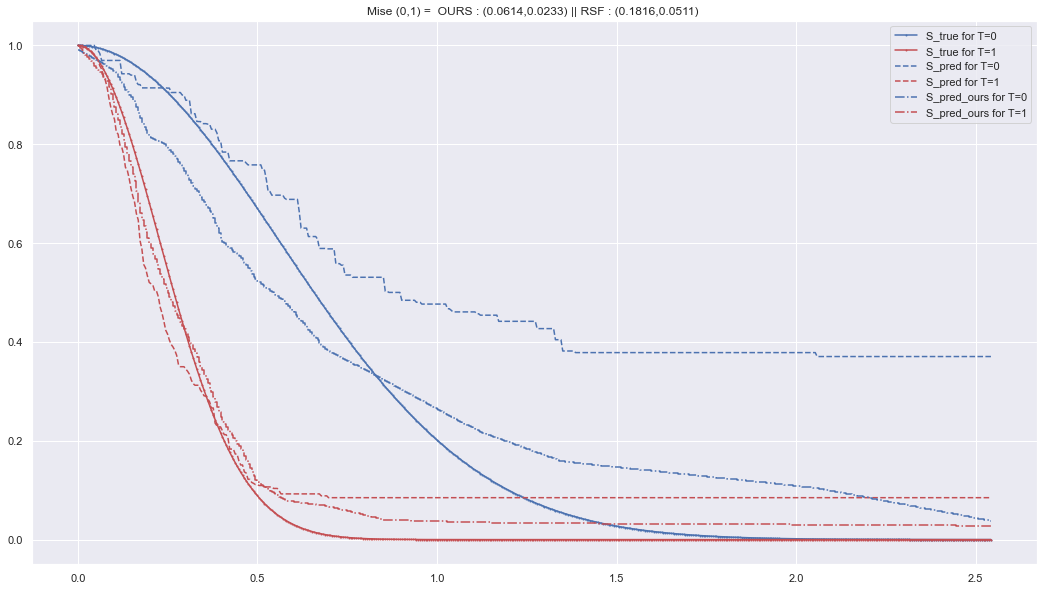

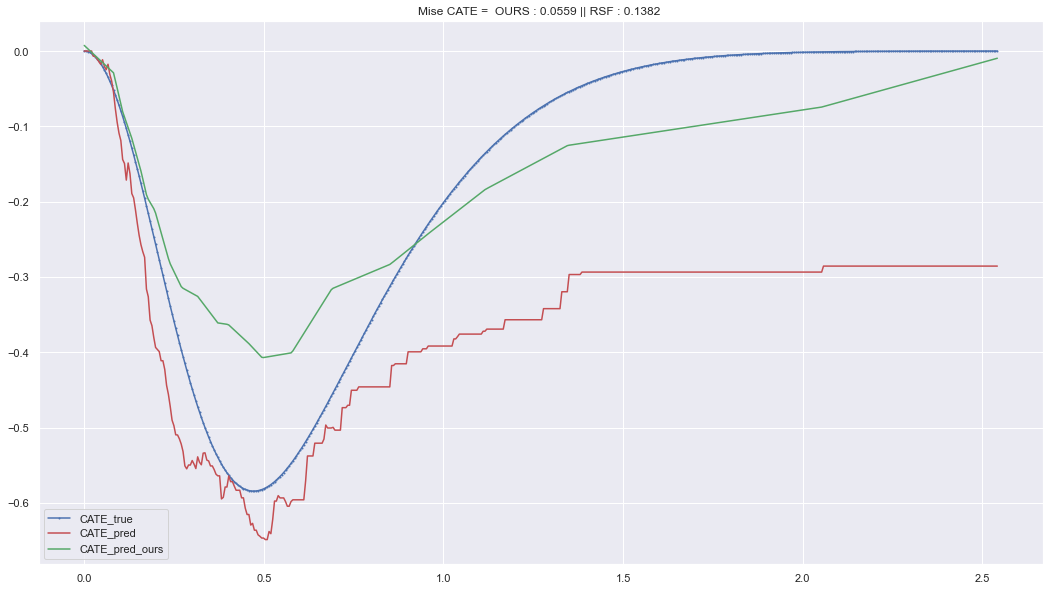

In [36]:

patient = 175
%matplotlib inline
d_q_all = {}
for model_name in Ev.list_models :
    fig_surv,fig_cate,d_q_model = plots(patient, Ev.d_list_models, model_name)
    d_q_all[model_name] = d_q_model
    nep.send_plot(fig_surv, "fig_surv_"+model_name,num_run=0)
    nep.send_plot(fig_cate, "fig_cate_"+model_name,num_run=0)


    



In [37]:

# dataframe of all the quantiles with the model name
df_q = pd.DataFrame(d_q_all)
nep.send_data(df_q, "df_q",num_run=0)
df_q


,SurvCaus,SurvCaus_0,BART,CoxPH,DeepSurv,EST,RSF
p,"[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]"
t*_0 true,"[1.2, 0.93, 0.75, 0.66, 0.42, 0.25]","[1.2, 0.93, 0.75, 0.66, 0.42, 0.25]","[1.2, 0.93, 0.75, 0.66, 0.42, 0.25]","[1.2, 0.93, 0.75, 0.66, 0.42, 0.25]","[1.2, 0.93, 0.75, 0.66, 0.42, 0.25]","[1.2, 0.93, 0.75, 0.66, 0.42, 0.25]","[1.2, 0.93, 0.75, 0.66, 0.42, 0.25]"
t*_0 pred,"[2.09, 1.03, 0.67, 0.54, 0.29, 0.14]","[1.87, 0.85, 0.51, 0.4, 0.19, 0.11]","[1.39, 1.39, 1.17, 0.94, 0.51, 0.3]","[1.46, 1.46, 1.46, 1.46, 1.46, 1.46]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[2.06, 2.06, 2.06, 1.39, 0.62, 0.33]","[2.06, 2.06, 1.33, 0.87, 0.51, 0.29]"
dif_0,0.376807,0.329899,0.292432,0.820396,0.768321,0.847732,0.633338
t*_1 true,"[0.49, 0.38, 0.31, 0.26, 0.17, 0.1]","[0.49, 0.38, 0.31, 0.26, 0.17, 0.1]","[0.49, 0.38, 0.31, 0.26, 0.17, 0.1]","[0.49, 0.38, 0.31, 0.26, 0.17, 0.1]","[0.49, 0.38, 0.31, 0.26, 0.17, 0.1]","[0.49, 0.38, 0.31, 0.26, 0.17, 0.1]","[0.49, 0.38, 0.31, 0.26, 0.17, 0.1]"
t*_1 pred,"[0.53, 0.4, 0.31, 0.25, 0.15, 0.09]","[0.82, 0.46, 0.34, 0.26, 0.16, 0.1]","[0.47, 0.36, 0.24, 0.22, 0.15, 0.1]","[0.26, 0.19, 0.17, 0.15, 0.1, 0.07]","[0.23, 0.18, 0.16, 0.15, 0.1, 0.08]","[0.7, 0.42, 0.29, 0.23, 0.14, 0.09]","[0.56, 0.38, 0.25, 0.21, 0.14, 0.09]"
dif_1,0.020817,0.139224,0.035824,0.145201,0.156791,0.089443,0.044721
dif,0.198812,0.234562,0.164128,0.482799,0.462556,0.468587,0.33903
